In [20]:
#!pip install tensorflow numpy matplotlib


In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [36]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [37]:
# Normalize pixel values to [0,1] and reshape for CNN input
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

In [38]:
# Add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [39]:
# Clip values to maintain valid range
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

In [40]:
# Define the autoencoder model
def build_autoencoder():
    input_img = tf.keras.layers.Input(shape=(28, 28, 1))

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = tf.keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    
    return autoencoder


In [41]:
# Build and train the autoencoder
autoencoder = build_autoencoder()
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.2465 - val_loss: 0.1201
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: 0.1181 - val_loss: 0.1103
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1102 - val_loss: 0.1060
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1063 - val_loss: 0.1038
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1038 - val_loss: 0.1017
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1019 - val_loss: 0.1002
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1009 - val_loss: 0.0993
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - loss: 0.1001 - val_loss: 0.0987
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.0990 - val_loss: 0.0978
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - loss: 0.0986 - val_loss: 0.0974


In [43]:
# Denoise test images
denoised_images = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [42]:
# Evaluate Model
test_loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Final Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0968
Final Test Loss: 0.0974


In [44]:
# Compute PSNR & SSIM
psnr_values = [psnr(x_test[i].squeeze(), denoised_images[i].squeeze()) for i in range(len(x_test))]
ssim_values = [ssim(x_test[i].squeeze(), denoised_images[i].squeeze(), data_range=1.0) for i in range(len(x_test))]

print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

Average PSNR: 19.75 dB
Average SSIM: 0.8637


In [48]:
# Plot original, noisy, and denoised images
def plot_images(noisy, denoised, n=10):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    
    plt.show()


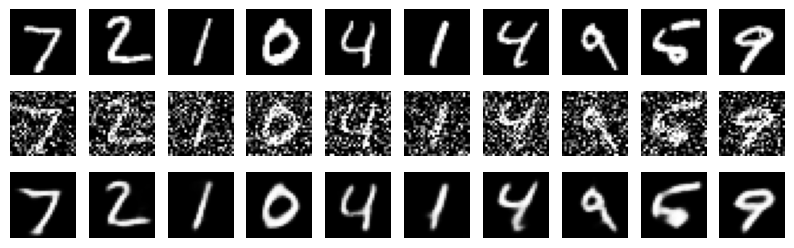

In [49]:
# Display results
plot_images(x_test_noisy, denoised_images)